In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
alphas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
betas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
criterion = 'l2-sp'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_CIFAR-10_ViT_B_16'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
tuned_df = pd.DataFrame(columns=columns)

for alpha, beta, lr_0, n, random_state in itertools.product(alphas, betas, lr_0s, ns, random_states):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    tuned_df.loc[len(tuned_df)] = row
    
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ViT_B_16'

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
retrained_df = pd.DataFrame(columns=columns)

for index, row in tuned_df.iterrows():
    temp_df = pd.read_csv(f'{experiments_directory}/{row.model_name}.csv')
    row = [row.criterion, row.model_name, row.n, row.random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    retrained_df.loc[len(retrained_df)] = row

retrained_df

,criterion,model_name,n,random_state,runtime,test_acc,test_nll
0,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=100_rand...,100,1001,6400.675935,0.7001,1.153008
1,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=100_rand...,100,2001,6218.688557,0.6672,1.351022
2,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=100_rand...,100,3001,6317.176212,0.7607,0.870238
3,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=1000_ran...,1000,1001,7565.746597,0.9276,0.266189
4,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=1000_ran...,1000,2001,7578.159678,0.9340,0.247210
...,...,...,...,...,...,...,...
1723,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=10000_r...,10000,2001,7653.826267,0.9479,0.217175
1724,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=10000_r...,10000,3001,7652.001014,0.9475,0.217068
1725,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=50000_r...,50000,1001,7610.645884,0.9503,0.217127
1726,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=50000_r...,50000,2001,7683.747710,0.9497,0.213176


In [3]:
tuned_df.to_csv('tuned_CIFAR-10_ViT_B_16.csv', index=False)
retrained_df.to_csv('retrained_CIFAR-10_ViT_B_16.csv', index=False)

In [4]:
tuned_cifar10_df = pd.read_csv('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/notebooks/tuned_CIFAR-10_ViT_B_16.csv')
retrained_cifar10_df = pd.read_csv('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/notebooks/retrained_CIFAR-10_ViT_B_16.csv')

In [5]:
alphas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
betas = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
criterion = 'l2-sp'
dataset_directory = '/cluster/tufts/hugheslab/eharve06/Oxford-IIIT_Pet'
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/tuned_Oxford-IIIT_Pet'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'val_acc', 'val_nll']
tuned_df = pd.DataFrame(columns=columns)

for alpha, beta, lr_0, n, random_state in itertools.product(alphas, betas, lr_0s, ns, random_states):
    model_name = f'{criterion}_alpha={alpha}_beta={beta}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [criterion, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    tuned_df.loc[len(tuned_df)] = row
    
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet'

columns = ['criterion', 'model_name', 'n', 'random_state', 'runtime', 'test_acc', 'test_nll']
retrained_df = pd.DataFrame(columns=columns)

for index, row in tuned_df.iterrows():
    temp_df = pd.read_csv(f'{experiments_directory}/{row.model_name}.csv')
    row = [row.criterion, row.model_name, row.n, row.random_state, temp_df['train_sec/epoch'].sum(), temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    retrained_df.loc[len(retrained_df)] = row

retrained_df

,criterion,model_name,n,random_state,runtime,test_acc,test_nll
0,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=370_rand...,370,1001,1370.007978,0.749886,0.960920
1,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=370_rand...,370,2001,1408.123719,0.755925,0.952158
2,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=370_rand...,370,3001,1401.989089,0.766192,0.933798
3,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=3441_ran...,3441,1001,1400.816236,0.928762,0.279900
4,l2-sp,l2-sp_alpha=0.01_beta=0.01_lr_0=0.1_n=3441_ran...,3441,2001,1403.407756,0.927361,0.277136
...,...,...,...,...,...,...,...
859,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=370_ran...,370,2001,1473.484066,0.878151,0.801126
860,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=370_ran...,370,3001,1411.118942,0.888890,0.807195
861,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=3441_ra...,3441,1001,2214.709541,0.869254,0.900682
862,l2-sp,l2-sp_alpha=0.0_beta=0.0_lr_0=0.0001_n=3441_ra...,3441,2001,1890.625961,0.870332,0.899985


In [6]:
tuned_df.to_csv('tuned_Oxford-IIIT_Pet_ResNet_50.csv', index=False)
retrained_df.to_csv('retrained_Oxford-IIIT_Pet_ResNet_50.csv', index=False)

In [7]:
tuned_oxfordiiit_pet_df = pd.read_csv('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/notebooks/tuned_Oxford-IIIT_Pet_ResNet_50.csv')
retrained_oxfordiiit_pet_df = pd.read_csv('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/notebooks/retrained_Oxford-IIIT_Pet_ResNet_50.csv')

In [11]:
cifar10_dictionary = np.load('CIFAR-10_ViT_B_16_dictionary.npy', allow_pickle=True).item()
oxfordiiit_pet_dictionary = np.load('Oxford-IIIT_Pet_ResNet_50_dictionary.npy', allow_pickle=True).item()

In [16]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_ViT_B_16_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [100, 1000, 10000, 50000]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
cifar10_vi_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={23528522/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    cifar10_vi_tuned_df.loc[len(cifar10_vi_tuned_df)] = row
    
min_indices = cifar10_vi_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
cifar10_vi_retrained_df = cifar10_vi_tuned_df.loc[min_indices]
cifar10_vi_retrained_df['total_time'] = cifar10_vi_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [17]:
experiments_directory = '/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_Oxford-IIIT_Pet_VI'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
methods = ['l2-sp']
ns = [370, 3441]
random_states = [1001, 2001, 3001]

columns = ['method', 'model_name', 'n', 'random_state', 'runtime', 'train_loss', 'test_acc', 'test_nll']
oxfordiiit_pet_vi_tuned_df = pd.DataFrame(columns=columns)

for lr_0, method, n, random_state in itertools.product(lr_0s, methods, ns, random_states):
    model_name = f'{method}_kappa={23583845/n}_lr_0={lr_0}_n={n}_random_state={random_state}'
    temp_df = pd.read_csv(f'{experiments_directory}/{model_name}.csv')
    row = [method, model_name, n, random_state, temp_df['train_sec/epoch'].sum(), temp_df.train_loss.values[-1], temp_df.val_or_test_acc.values[-1], temp_df.val_or_test_nll.values[-1]]
    oxfordiiit_pet_vi_tuned_df.loc[len(oxfordiiit_pet_vi_tuned_df)] = row
    
min_indices = oxfordiiit_pet_vi_tuned_df.groupby(['method', 'n', 'random_state'])['train_loss'].idxmin()
oxfordiiit_pet_vi_retrained_df = oxfordiiit_pet_vi_tuned_df.loc[min_indices]
oxfordiiit_pet_vi_retrained_df['total_time'] = oxfordiiit_pet_vi_tuned_df.groupby(['method', 'n', 'random_state'])['runtime'].sum().values   

In [18]:
def plot_dictionary(ax, bootstrap_dictionary, n, random_states, markers=['o', '^', 's']):
    for index, random_state in enumerate(random_states):
        x = bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(0,2,))
        y = bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(0,2,))
        lower_x, upper_x = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,0].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        lower_y, upper_y = np.percentile(bootstrap_dictionary[n][random_state][:,:,:,1].mean(axis=(2,)), [2.5, 97.5], axis=(0,))
        ax.scatter(x[-1]/3600, y[-1], color='#1F77B4', marker=markers[index], zorder=3)
        ax.plot(x/3600, y, color='#1F77B4', zorder=2)
        ax.fill_between(x/3600, lower_y, upper_y, alpha=0.1, color='#1F77B4', zorder=2)

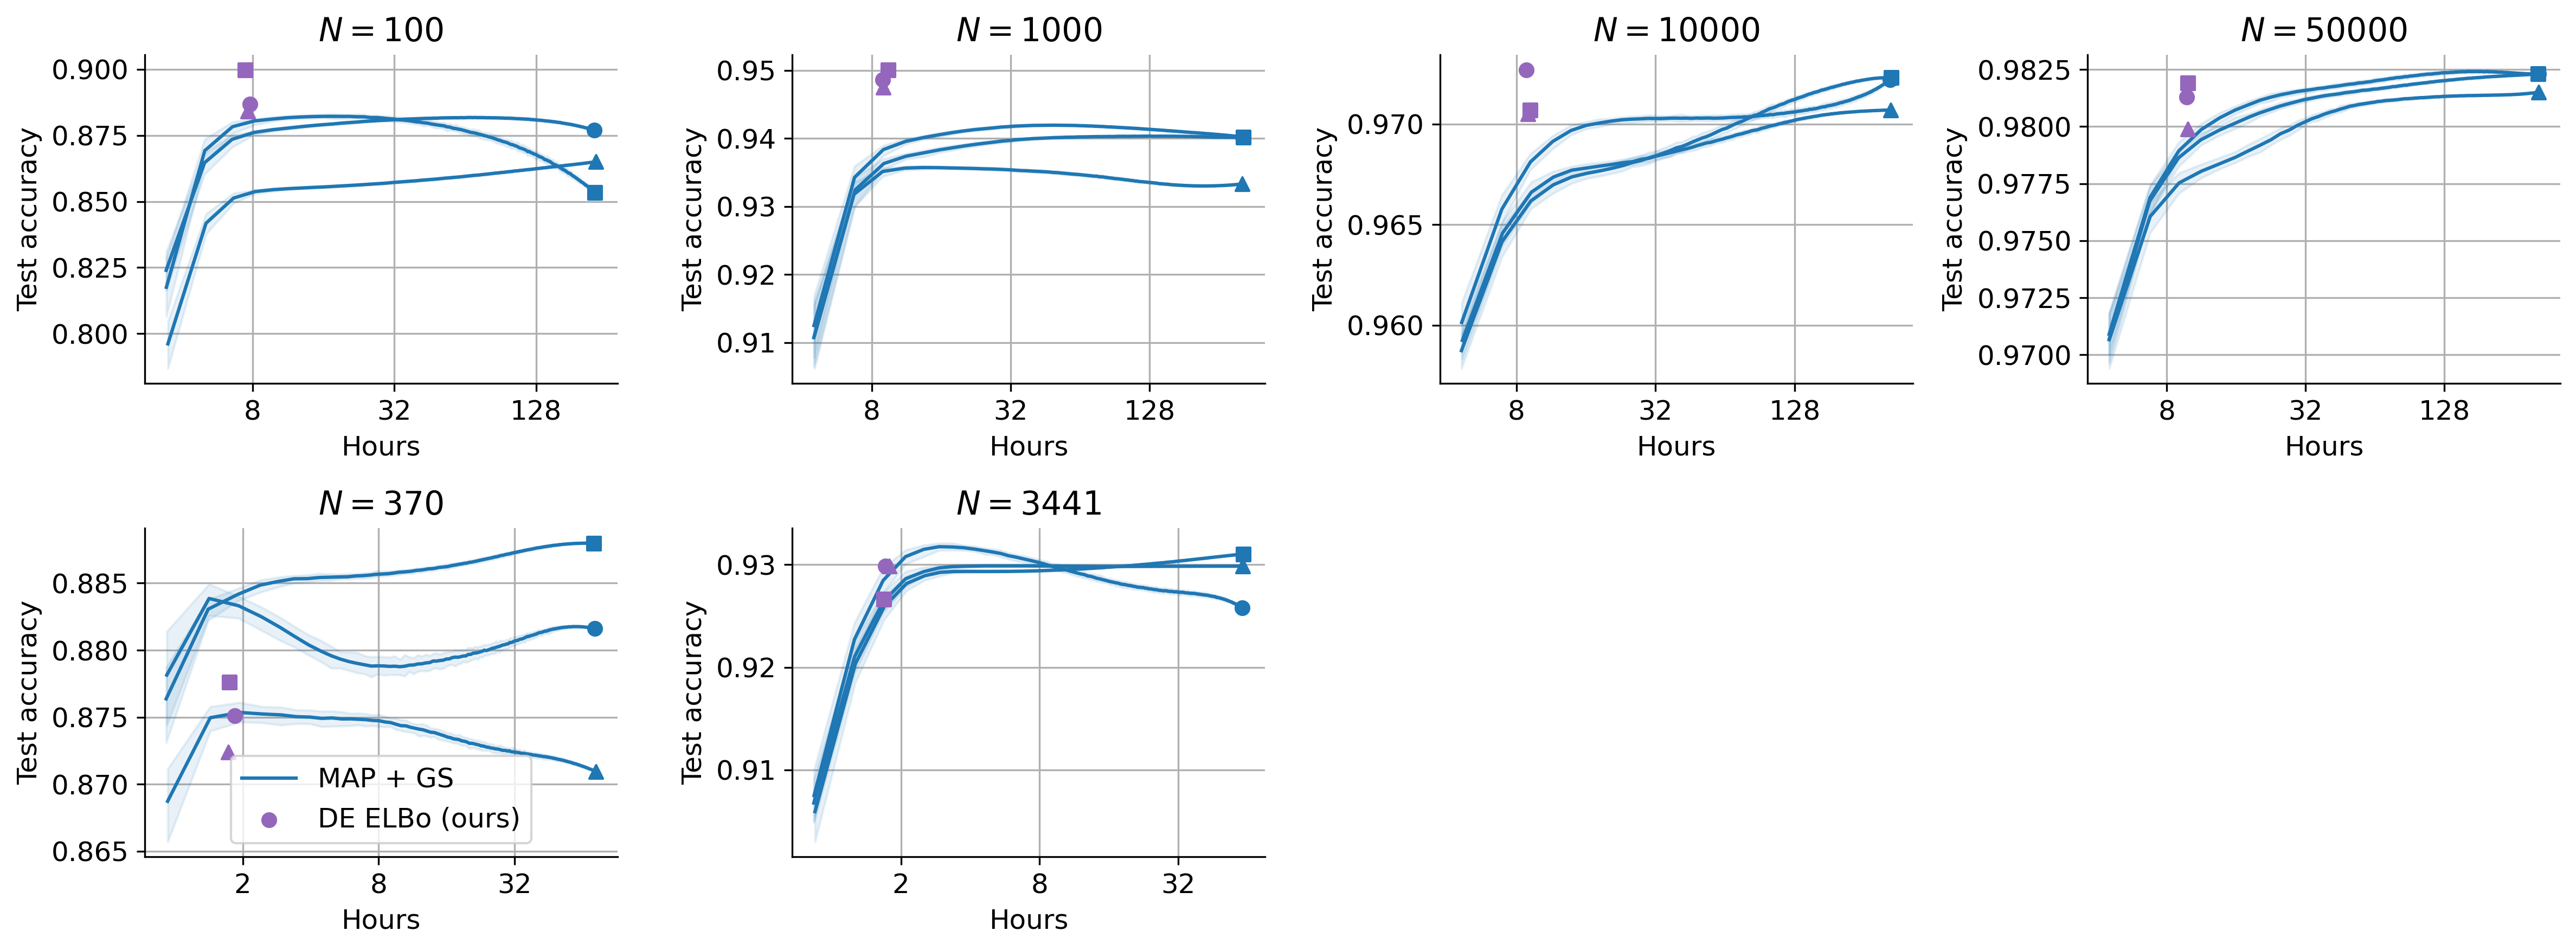

In [19]:
markers = ['o', '^', 's']

ncols, nrows = 4, 2
fig, axs = plt.subplots(dpi=300, figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)
for index, (time, acc) in enumerate(zip(cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==100].total_time.values/3600, cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==100].test_acc.values)):
    axs[0,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[0,0], cifar10_dictionary, 100, [1001, 2001, 3001])
axs[0,0].set_xscale('log', base=2)
ticks = axs[0,0].get_xticks()
axs[0,0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,0].spines[['right', 'top']].set_visible(False)
axs[0,0].set_title(r'$N=100$')
axs[0,0].set_xlabel('Hours')
axs[0,0].set_ylabel('Test accuracy')
axs[0,0].grid()
for index, (time, acc) in enumerate(zip(cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==1000].total_time.values/3600, cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==1000].test_acc.values)):
    axs[0,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[0,1], cifar10_dictionary, 1000, [1001, 2001, 3001])
axs[0,1].set_xscale('log', base=2)
ticks = axs[0,1].get_xticks()
axs[0,1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,1].spines[['right', 'top']].set_visible(False)
axs[0,1].set_title(r'$N=1000$')
axs[0,1].set_xlabel('Hours')
axs[0,1].set_ylabel('Test accuracy')
axs[0,1].grid()
for index, (time, acc) in enumerate(zip(cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==10000].total_time.values/3600, cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==10000].test_acc.values)):
    axs[0,2].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[0,2], cifar10_dictionary, 10000, [1001, 2001, 3001])
axs[0,2].set_xscale('log', base=2)
ticks = axs[0,2].get_xticks()
axs[0,2].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,2].spines[['right', 'top']].set_visible(False)
axs[0,2].set_title(r'$N=10000$')
axs[0,2].set_xlabel('Hours')
axs[0,2].set_ylabel('Test accuracy')
axs[0,2].grid()
for index, (time, acc) in enumerate(zip(cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==50000].total_time.values/3600, cifar10_vi_retrained_df[cifar10_vi_retrained_df.n==50000].test_acc.values)):
    axs[0,3].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[0,3], cifar10_dictionary, 50000, [1001, 2001, 3001])
axs[0,3].set_xscale('log', base=2)
ticks = axs[0,3].get_xticks()
axs[0,3].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[0,3].spines[['right', 'top']].set_visible(False)
axs[0,3].set_title(r'$N=50000$')
axs[0,3].set_xlabel('Hours')
axs[0,3].set_ylabel('Test accuracy')
axs[0,3].grid()

axs[1,0].plot([], [], color='#1F77B4', label='MAP + GS', zorder=3)
axs[1,0].scatter([], [], color='#9467BD', label='DE ELBo (ours)', zorder=3)
for index, (time, acc) in enumerate(zip(oxfordiiit_pet_vi_retrained_df[oxfordiiit_pet_vi_retrained_df.n==370].total_time.values/3600, oxfordiiit_pet_vi_retrained_df[oxfordiiit_pet_vi_retrained_df.n==370].test_acc.values)):
    axs[1,0].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[1,0], oxfordiiit_pet_dictionary, 370, [1001, 2001, 3001])
axs[1,0].set_xscale('log', base=2)
ticks = axs[1,0].get_xticks()
axs[1,0].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,0].spines[['right', 'top']].set_visible(False)
axs[1,0].set_title(r'$N=370$')
axs[1,0].set_xlabel('Hours')
axs[1,0].set_ylabel('Test accuracy')
axs[1,0].grid()
axs[1,0].legend()

for index, (time, acc) in enumerate(zip(oxfordiiit_pet_vi_retrained_df[oxfordiiit_pet_vi_retrained_df.n==3441].total_time.values/3600, oxfordiiit_pet_vi_retrained_df[oxfordiiit_pet_vi_retrained_df.n==3441].test_acc.values)):
    axs[1,1].scatter(time, acc, color='#9467BD', marker=markers[index], zorder=3)
plot_dictionary(axs[1,1], oxfordiiit_pet_dictionary, 3441, [1001, 2001, 3001])
axs[1,1].set_xscale('log', base=2)
ticks = axs[1,1].get_xticks()
axs[1,1].set_xticks([int(tick) for tick in ticks[2:-2]], [int(tick) for tick in ticks[2:-2]])
axs[1,1].spines[['right', 'top']].set_visible(False)
axs[1,1].set_title(r'$N=3441$')
axs[1,1].set_xlabel('Hours')
axs[1,1].set_ylabel('Test accuracy')
axs[1,1].grid()

axs[1,2].axis('off')
axs[1,3].axis('off')

fig.tight_layout()
fig.savefig('computational_time_comparison.pdf', bbox_inches='tight')
plt.show()